In [41]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# pip install required packages
!pip install mne pandas matplotlib numpy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from math import ceil

import zipfile
import os

zip_path = '/content/drive/MyDrive/EEG.machinelearing_data_BRMH.csv.zip'
extract_path = '/content/EEG_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
os.listdir(extract_path)
import pandas as pd

# Try to find CSV inside extracted folder
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print("CSV files found:", csv_files)

data_path = os.path.join(extract_path, csv_files[0])
df = pd.read_csv(data_path)

print("Shape:", df.shape)
df.head()


Files extracted to: /content/EEG_dataset
CSV files found: ['EEG.machinelearing_data_BRMH.csv']
Shape: (945, 1149)


no. sex   age    eeg.date  education     IQ       main.disorder  \
0    1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1    2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2    3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3    4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4    5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   

      specific.disorder  AB.A.delta.a.FP1  AB.A.delta.b.FP2  ...  \
0  Alcohol use disorder         35.998557         21.717375  ...   
1  Alcohol use disorder         13.425118         11.002916  ...   
2  Alcohol use disorder         29.941780         27.544684  ...   
3  Alcohol use disorder         21.496226         21.846832  ...   
4  Alcohol use disorder         37.775667         33.607679  ...   

   COH.F.gamma.o.Pz.p.P4  COH.F.gamma.o.Pz.q.T6  COH.F.gamma.o.Pz.r.O1  \
0              55.989192              16.739679              23.452271   
1              45.595619              17.510824              26.777368   
2              99.475453              70.654171              39.131547   
3              59.986561              63.822201              36.478254   
4              61.462720              59.166097              51.465531   

   COH.F.gamma.o.Pz.s.O2  COH.F.gamma.p.P4.q.T6  COH.F.gamma.p.P4.r.O1  \
0              45.678820              30.167520              16.918761   
1              28.201062              57.108861              32.375401   
2              69.920996              71.063644              38.534505   
3              47.117006              84.658376              24.724096   
4              58.635415              80.685608              62.138436   

   COH.F.gamma.p.P4.s.O2  COH.F.gamma.q.T6.r.O1  COH.F.gamma.q.T6.s.O2  \
0              48.850427               9.422630              34.507082   
1              60.351749              13.900981              57.831848   
2              69.908764              27.180532              64.803155   
3              50.299349              35.319695              79.822944   
4              75.888749              61.003944              87.455509   

   COH.F.gamma.r.O1.s.O2  
0              28.613029  
1              43.463261  
2              31.485799  
3              41.141873  
4              70.531662  

[5 rows x 1149 columns]

In [43]:
# Identify columns that are completely empty (all NaN)
mis = df.isna().sum()
all_empty = mis[mis == df.shape[0]]
print("Fully-empty columns:", list(all_empty.index[:5]), " ... total:", len(all_empty))

# If there is at least one, assume the first such column is the separator (same logic as original)
if len(all_empty) > 0:
    sep_col = all_empty.index[0]

    start_col = 'main.disorder'
    df = df.loc[:, start_col:sep_col].drop(sep_col, axis=1)
    print("Trimmed df shape:", df.shape)
else:
    print("No fully-empty separator column found; skipping trimming.")


Fully-empty columns: ['Unnamed: 122']  ... total: 1
Trimmed df shape: (945, 116)


In [44]:
# Example preview of column names
cols_preview = df.columns.tolist()[:30]
cols_preview


['main.disorder',
 'specific.disorder',
 'AB.A.delta.a.FP1',
 'AB.A.delta.b.FP2',
 'AB.A.delta.c.F7',
 'AB.A.delta.d.F3',
 'AB.A.delta.e.Fz',
 'AB.A.delta.f.F4',
 'AB.A.delta.g.F8',
 'AB.A.delta.h.T3',
 'AB.A.delta.i.C3',
 'AB.A.delta.j.Cz',
 'AB.A.delta.k.C4',
 'AB.A.delta.l.T4',
 'AB.A.delta.m.T5',
 'AB.A.delta.n.P3',
 'AB.A.delta.o.Pz',
 'AB.A.delta.p.P4',
 'AB.A.delta.q.T6',
 'AB.A.delta.r.O1',
 'AB.A.delta.s.O2',
 'AB.B.theta.a.FP1',
 'AB.B.theta.b.FP2',
 'AB.B.theta.c.F7',
 'AB.B.theta.d.F3',
 'AB.B.theta.e.Fz',
 'AB.B.theta.f.F4',
 'AB.B.theta.g.F8',
 'AB.B.theta.h.T3',
 'AB.B.theta.i.C3']

In [45]:
def reformat_name(name):

    if '.' not in name:
        return name
    parts = name.split('.')

    bands = ['delta','theta','alpha','beta','gamma','lowalpha','highalpha']
    band = None
    chan = None
    for p in parts:
        p_lower = p.lower()
        if p_lower in bands:
            band = p_lower
    # assume channel is the last part that looks like an electrode (letters+digits)
    possible_chan = [p for p in parts[::-1] if any(c.isalpha() for c in p)]
    if len(possible_chan) > 0:
        chan = possible_chan[0]
    if band and chan:
        return f"{band}.{chan.upper()}"
    # fallback: return original
    return name

# Apply to columns except the metadata columns on the left (detect metadata by dtype or known names)
meta_cols = []
# try to detect first few metadata columns:
possible_meta = ['main.disorder','specific.disorder','patient','id','label']
for m in possible_meta:
    if m in df.columns:
        meta_cols.append(m)


if len(meta_cols) == 0:
    meta_cols = df.columns[:6].tolist()

print("Metadata columns detected:", meta_cols)

# Rename only the non-meta columns
data_cols = [c for c in df.columns if c not in meta_cols]
renamed = {c: reformat_name(c) for c in data_cols}
df = df.rename(columns=renamed)
print("Example renamed columns:", list(renamed.items())[:8])

# Show new columns preview
df.columns.tolist()[:30]


Metadata columns detected: ['main.disorder', 'specific.disorder']
Example renamed columns: [('AB.A.delta.a.FP1', 'delta.FP1'), ('AB.A.delta.b.FP2', 'delta.FP2'), ('AB.A.delta.c.F7', 'delta.F7'), ('AB.A.delta.d.F3', 'delta.F3'), ('AB.A.delta.e.Fz', 'delta.FZ'), ('AB.A.delta.f.F4', 'delta.F4'), ('AB.A.delta.g.F8', 'delta.F8'), ('AB.A.delta.h.T3', 'delta.T3')]


['main.disorder',
 'specific.disorder',
 'delta.FP1',
 'delta.FP2',
 'delta.F7',
 'delta.F3',
 'delta.FZ',
 'delta.F4',
 'delta.F8',
 'delta.T3',
 'delta.C3',
 'delta.CZ',
 'delta.C4',
 'delta.T4',
 'delta.T5',
 'delta.P3',
 'delta.PZ',
 'delta.P4',
 'delta.T6',
 'delta.O1',
 'delta.O2',
 'theta.FP1',
 'theta.FP2',
 'theta.F7',
 'theta.F3',
 'theta.FZ',
 'theta.F4',
 'theta.F8',
 'theta.T3',
 'theta.C3']

In [46]:
# Make metadata df and eeg features df
meta_cols = [c for c in df.columns if not ('.' in c)]  # heuristic: metadata columns don't contain a dot
meta_df = df[meta_cols].copy()
eeg_cols = [c for c in df.columns if '.' in c]
eeg_df = df[eeg_cols].copy()

print("Metadata columns:", meta_df.columns.tolist())
print("EEG feature columns count:", len(eeg_cols))
print("EEG df shape:", eeg_df.shape)
eeg_df.iloc[:3, :6]  # show small snippet


Metadata columns: []
EEG feature columns count: 116
EEG df shape: (945, 116)


main.disorder     specific.disorder  delta.FP1  delta.FP2   delta.F7  \
0  Addictive disorder  Alcohol use disorder  35.998557  21.717375  21.518280   
1  Addictive disorder  Alcohol use disorder  13.425118  11.002916  11.942516   
2  Addictive disorder  Alcohol use disorder  29.941780  27.544684  17.150159   

    delta.F3  
0  26.825048  
1  15.272216  
2  23.608960

In [47]:
# Ensure columns are unique
assert len(set(eeg_df.columns)) == len(eeg_df.columns), "duplicate columns detected"

# Attach metadata back for grouping
full = pd.concat([meta_df.reset_index(drop=True), eeg_df.reset_index(drop=True)], axis=1)
print("Full df shape (meta + eeg):", full.shape)


Full df shape (meta + eeg): (945, 116)


fix


In [48]:
# this to inspect the real column names and sample values
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 200)

print("Full df shape (as currently in memory):", df.shape)
print("\nFirst 80 column names:")
print(df.columns.tolist()[:80])   # adjust slice if you want to see more

# Show dtypes and number of unique values for the first 60 columns
cols = df.columns.tolist()
meta_scan = pd.DataFrame({
    'col': cols[:60],
    'dtype': [df[c].dtype for c in cols[:60]],
    'n_unique': [df[c].nunique(dropna=False) for c in cols[:60]],
    'sample_values': [df[c].dropna().unique()[:5].tolist() for c in cols[:60]]
})
meta_scan


Full df shape (as currently in memory): (945, 116)

First 80 column names:
['main.disorder', 'specific.disorder', 'delta.FP1', 'delta.FP2', 'delta.F7', 'delta.F3', 'delta.FZ', 'delta.F4', 'delta.F8', 'delta.T3', 'delta.C3', 'delta.CZ', 'delta.C4', 'delta.T4', 'delta.T5', 'delta.P3', 'delta.PZ', 'delta.P4', 'delta.T6', 'delta.O1', 'delta.O2', 'theta.FP1', 'theta.FP2', 'theta.F7', 'theta.F3', 'theta.FZ', 'theta.F4', 'theta.F8', 'theta.T3', 'theta.C3', 'theta.CZ', 'theta.C4', 'theta.T4', 'theta.T5', 'theta.P3', 'theta.PZ', 'theta.P4', 'theta.T6', 'theta.O1', 'theta.O2', 'alpha.FP1', 'alpha.FP2', 'alpha.F7', 'alpha.F3', 'alpha.FZ', 'alpha.F4', 'alpha.F8', 'alpha.T3', 'alpha.C3', 'alpha.CZ', 'alpha.C4', 'alpha.T4', 'alpha.T5', 'alpha.P3', 'alpha.PZ', 'alpha.P4', 'alpha.T6', 'alpha.O1', 'alpha.O2', 'beta.FP1', 'beta.FP2', 'beta.F7', 'beta.F3', 'beta.FZ', 'beta.F4', 'beta.F8', 'beta.T3', 'beta.C3', 'beta.CZ', 'beta.C4', 'beta.T4', 'beta.T5', 'beta.P3', 'beta.PZ', 'beta.P4', 'beta.T6', 'beta.O

col    dtype  n_unique  \
0       main.disorder   object         7   
1   specific.disorder   object        12   
2           delta.FP1  float64       942   
3           delta.FP2  float64       942   
4            delta.F7  float64       942   
5            delta.F3  float64       942   
6            delta.FZ  float64       942   
7            delta.F4  float64       942   
8            delta.F8  float64       942   
9            delta.T3  float64       942   
10           delta.C3  float64       942   
11           delta.CZ  float64       942   
12           delta.C4  float64       942   
13           delta.T4  float64       942   
14           delta.T5  float64       942   
15           delta.P3  float64       942   
16           delta.PZ  float64       942   
17           delta.P4  float64       942   
18           delta.T6  float64       942   
19           delta.O1  float64       942   
20           delta.O2  float64       942   
21          theta.FP1  float64       942   
22          theta.FP2  float64       942   
23           theta.F7  float64       942   
24           theta.F3  float64       942   
25           theta.FZ  float64       942   
26           theta.F4  float64       942   
27           theta.F8  float64       940   
28           theta.T3  float64       942   
29           theta.C3  float64       942   
30           theta.CZ  float64       942   
31           theta.C4  float64       942   
32           theta.T4  float64       942   
33           theta.T5  float64       942   
34           theta.P3  float64       942   
35           theta.PZ  float64       942   
36           theta.P4  float64       942   
37           theta.T6  float64       942   
38           theta.O1  float64       942   
39           theta.O2  float64       942   
40          alpha.FP1  float64       942   
41          alpha.FP2  float64       942   
42           alpha.F7  float64       942   
43           alpha.F3  float64       942   
44           alpha.FZ  float64       942   
45           alpha.F4  float64       941   
46           alpha.F8  float64       942   
47           alpha.T3  float64       942   
48           alpha.C3  float64       942   
49           alpha.CZ  float64       942   
50           alpha.C4  float64       942   
51           alpha.T4  float64       941   
52           alpha.T5  float64       942   
53           alpha.P3  float64       942   
54           alpha.PZ  float64       942   
55           alpha.P4  float64       942   
56           alpha.T6  float64       942   
57           alpha.O1  float64       942   
58           alpha.O2  float64       942   
59           beta.FP1  float64       942   

                                                                                                              sample_values  
0   [Addictive disorder, Trauma and stress related disorder, Mood disorder, Healthy control, Obsessive compulsive disorder]  
1        [Alcohol use disorder, Acute stress disorder, Depressive disorder, Healthy control, Behavioral addiction disorder]  
2                                                                    [35.998557, 13.425118, 29.94178, 21.496226, 37.775667]  
3                                                                   [21.717375, 11.002916, 27.544684, 21.846832, 33.607679]  
4                                                                    [21.51828, 11.942516, 17.150159, 17.364316, 21.865556]  
5                                                                    [26.825048, 15.272216, 23.60896, 13.833701, 21.771413]  
6                                                                    [26.611516, 14.15157, 27.087811, 14.100954, 22.854536]  
7                                                                   [25.732649, 12.456034, 13.541237, 13.100939, 21.456377]  
8                                                                     [16.563408, 8.436832, 16.523963, 14.61365, 15.969042]  
9                                                                      [2

In [49]:
# Candidate keywords that suggest a metadata/disorder column
keywords = ['disorder', 'patient', 'id', 'group', 'label', 'diagnosis', 'main', 'specific']

# Heuristic detection:
meta_cols = []
for c in df.columns:
    # If column dtype is object and has low cardinality, it's likely metadata
    if df[c].dtype == 'object':
        nunique = df[c].nunique(dropna=False)
        # pick as metadata if unique count is much smaller than rows (e.g., < 0.2 * n_rows)
        if nunique < 0.2 * df.shape[0] or any(k in c.lower() for k in keywords):
            meta_cols.append(c)
    # numeric columns could still be metadata (like age) so check small unique numeric columns too
    else:
        nunique = df[c].nunique(dropna=False)
        if nunique < 10 and any(k in c.lower() for k in keywords):
            meta_cols.append(c)

# Fallback: if nothing found, try finding columns that contain the words in samples
if len(meta_cols) == 0:
    for c in df.columns:
        sample = df[c].astype(str).head(30).str.lower().tolist()
        if any(any(kw in s for kw in keywords) for s in sample):
            meta_cols.append(c)

# If still empty, fall back to the original first-6 heuristic (but warn)
if len(meta_cols) == 0:
    meta_cols = df.columns[:6].tolist()
    print("Warning: automatic meta detection failed — falling back to first 6 columns as metadata:", meta_cols)

print("Detected metadata columns (heuristic):", meta_cols)
print("Number of metadata cols:", len(meta_cols))

# Now treat the rest as EEG feature columns
eeg_cols = [c for c in df.columns if c not in meta_cols]
print("EEG feature column count (heuristic):", len(eeg_cols))

# Show the first few detected meta columns with their sample values
for c in meta_cols[:10]:
    print("\nColumn:", c)
    print(df[c].value_counts().head(10))


Detected metadata columns (heuristic): ['main.disorder', 'specific.disorder']
Number of metadata cols: 2
EEG feature column count (heuristic): 114

Column: main.disorder
main.disorder
Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: count, dtype: int64

Column: specific.disorder
specific.disorder
Depressive disorder               199
Schizophrenia                     117
Healthy control                    95
Alcohol use disorder               93
Behavioral addiction disorder      93
Bipolar disorder                   67
Panic disorder                     59
Posttraumatic stress disorder      52
Social anxiety disorder            48
Obsessive compulsitve disorder     46
Name: count, dtype: int64


In [50]:
# Coerce eeg feature columns to numeric
non_numeric_cols = []
for c in eeg_cols:
    # try converting and count number of non-numeric entries
    converted = pd.to_numeric(df[c], errors='coerce')
    n_non_numeric = converted.isna().sum() - df[c].isna().sum()  # new NaNs introduced by coercion
    if n_non_numeric > 0:
        non_numeric_cols.append((c, int(n_non_numeric)))
    df[c] = converted

print("Columns that had non-numeric entries (col, #non-numeric introduced):")
print(non_numeric_cols[:10])
print("Total columns with coercion issues:", len(non_numeric_cols))

# If many non-numeric issues exist, print a small sample
if len(non_numeric_cols) > 0:
    print("\nSample problematic columns + head of values:")
    for c, cnt in non_numeric_cols[:5]:
        print("\nColumn:", c)
        print(df[c].head(8))


Columns that had non-numeric entries (col, #non-numeric introduced):
[]
Total columns with coercion issues: 0


In [51]:
meta_df = df[meta_cols].copy()
eeg_df = df[eeg_cols].copy()

print("meta_df shape:", meta_df.shape)
print("eeg_df shape:", eeg_df.shape)
print("Example metadata columns:", meta_df.columns.tolist()[:10])
print("Example EEG columns:", eeg_df.columns.tolist()[:10])


meta_df shape: (945, 2)
eeg_df shape: (945, 114)
Example metadata columns: ['main.disorder', 'specific.disorder']
Example EEG columns: ['delta.FP1', 'delta.FP2', 'delta.F7', 'delta.F3', 'delta.FZ', 'delta.F4', 'delta.F8', 'delta.T3', 'delta.C3', 'delta.CZ']


In [52]:
# Choose correct column names for grouping (update if your metadata names differ)
# If the heuristic found something that looks like the disorder column, prefer that.
cand_main = [c for c in meta_cols if 'main' in c.lower() or 'main.disorder' in c.lower()]
cand_spec = [c for c in meta_cols if 'specific' in c.lower() or 'specific.disorder' in c.lower()]

# fallback: try to find by keywords in the values (most frequent string that contains 'disorder' etc.)
if len(cand_main) == 0:
    for c in meta_cols:
        vals = meta_df[c].astype(str).str.lower()
        if vals.str.contains('disorder').any() or vals.str.contains('control').any():
            cand_main.append(c)
if len(cand_spec) == 0:
    for c in meta_cols:
        vals = meta_df[c].astype(str).str.lower()
        if vals.str.contains('depress') or vals.str.contains('ptsd') or vals.str.contains('anxiety'):
            cand_spec.append(c)

# Final selection (or set manually if needed)
main_col = cand_main[0] if len(cand_main) > 0 else (meta_cols[0] if len(meta_cols)>0 else None)
specific_col = cand_spec[0] if len(cand_spec) > 0 else (meta_cols[1] if len(meta_cols)>1 else main_col)

print("Using main_col =", main_col)
print("Using specific_col =", specific_col)

# Now compute means — only numeric eeg_df columns
numeric_eeg_cols = eeg_df.select_dtypes(include=[np.number]).columns.tolist()
print("Number of numeric EEG columns:", len(numeric_eeg_cols))

main_mean = pd.concat([meta_df[main_col], eeg_df[numeric_eeg_cols]], axis=1).groupby(main_col).mean()
specific_mean = pd.concat([meta_df[specific_col], eeg_df[numeric_eeg_cols]], axis=1).groupby(specific_col).mean()

print("main_mean shape:", main_mean.shape)
print("specific_mean shape:", specific_mean.shape)


Using main_col = main.disorder
Using specific_col = specific.disorder
Number of numeric EEG columns: 114
main_mean shape: (7, 114)
specific_mean shape: (12, 114)


In [53]:
# Check for disorder columns
print("Columns in metadata:", meta_df.columns.tolist()[:10])

# The names used in original notebook:
main_col = 'main.disorder'      # <-- CHANGE if your column name differs
specific_col = 'specific.disorder'  # <-- CHANGE if your column name differs

# Verify existence
for c in [main_col, specific_col]:
    if c not in full.columns:
        raise ValueError(f"Column '{c}' not found in your data. Please update the variable names.")

# group means
main_mean = full.groupby(main_col)[eeg_cols].mean()
specific_mean = full.groupby(specific_col)[eeg_cols].mean()

print("main_mean shape:", main_mean.shape)
print("specific_mean shape:", specific_mean.shape)


Columns in metadata: ['main.disorder', 'specific.disorder']
main_mean shape: (7, 114)
specific_mean shape: (12, 114)


visualization

/tmp/ipython-input-4069760574.py:22: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  fig = mont.plot(show_names=True)


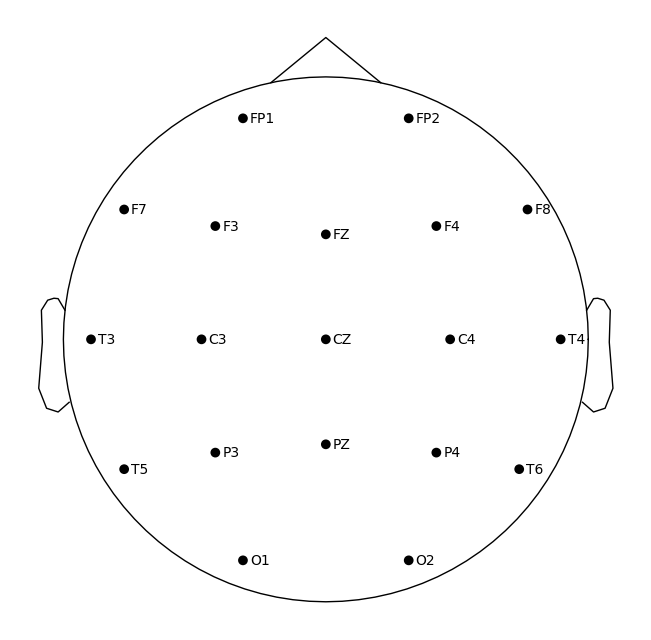

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import mne
from math import ceil

#  You can keep or adjust these if your channels differ
chs = {
    'FP1': [-0.03, 0.08], 'FP2': [0.03, 0.08],
    'F7': [-0.073, 0.047], 'F3': [-0.04, 0.041],
    'FZ': [0, 0.038], 'F4': [0.04, 0.041], 'F8': [0.073, 0.047],
    'T3': [-0.085, 0], 'C3': [-0.045, 0], 'CZ': [0, 0],
    'C4': [0.045, 0], 'T4': [0.085, 0], 'T5': [-0.073, -0.047],
    'P3': [-0.04, -0.041], 'PZ': [0, -0.038], 'P4': [0.04, -0.041],
    'T6': [0.07, -0.047], 'O1': [-0.03, -0.08], 'O2': [0.03, -0.08]
}

# Convert to 3D coordinates
for key in chs.keys():
    chs[key] += [0]

mont = mne.channels.make_dig_montage(chs)
fig = mont.plot(show_names=True)
plt.show()


In [55]:
# Get all band names and channel names from column labels like "alpha.F3"
bands = sorted(set([c.split('.')[0] for c in main_mean.columns]))
channels = sorted(set([c.split('.')[1].upper() for c in main_mean.columns]))

print("Detected EEG Bands:", bands)
print("Detected Channels:", channels)


Detected EEG Bands: ['AB', 'alpha', 'beta', 'delta', 'gamma', 'theta']
Detected Channels: ['C3', 'C4', 'CZ', 'E', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'O1', 'O2', 'P3', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6']


In [56]:
print(main_mean.index.tolist())


['Addictive disorder', 'Anxiety disorder', 'Healthy control', 'Mood disorder', 'Obsessive compulsive disorder', 'Schizophrenia', 'Trauma and stress related disorder']


In [57]:
def plot_eeg(levels, positions, ax, fig, ch_names=None,
             cmap='Spectral_r', vmin=None, vmax=None, marker=None):
    """
    Draw a simple topomap for EEG data values.
    levels : 1D array of values (one per channel)
    positions : dict of 3D coordinates (e.g., from 'chs')
    """
    coords = np.array(list(positions.values()))[:, :2]  # use only X,Y

    # Try using vmin/vmax if supported; otherwise, fallback gracefully
    try:
        im, _ = mne.viz.plot_topomap(
            levels, coords, axes=ax, show=False, cmap=cmap,
            vlim=(vmin, vmax) if vmin is not None else None
        )
    except TypeError:
        # For older/newer versions without vlim support
        im, _ = mne.viz.plot_topomap(
            levels, coords, axes=ax, show=False, cmap=cmap
        )

    ax.set_title(ch_names, fontsize=10)
    return im


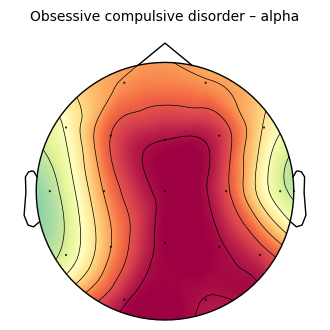

In [58]:
example_disorder = 'Obsessive compulsive disorder'
example_band = 'alpha'

example_values = main_mean.loc[example_disorder, main_mean.columns.str.startswith(example_band)].to_numpy()

fig, ax = plt.subplots(figsize=(4,4))
plot_eeg(example_values, chs, ax, fig, ch_names=f"{example_disorder} – {example_band}")
plt.show()


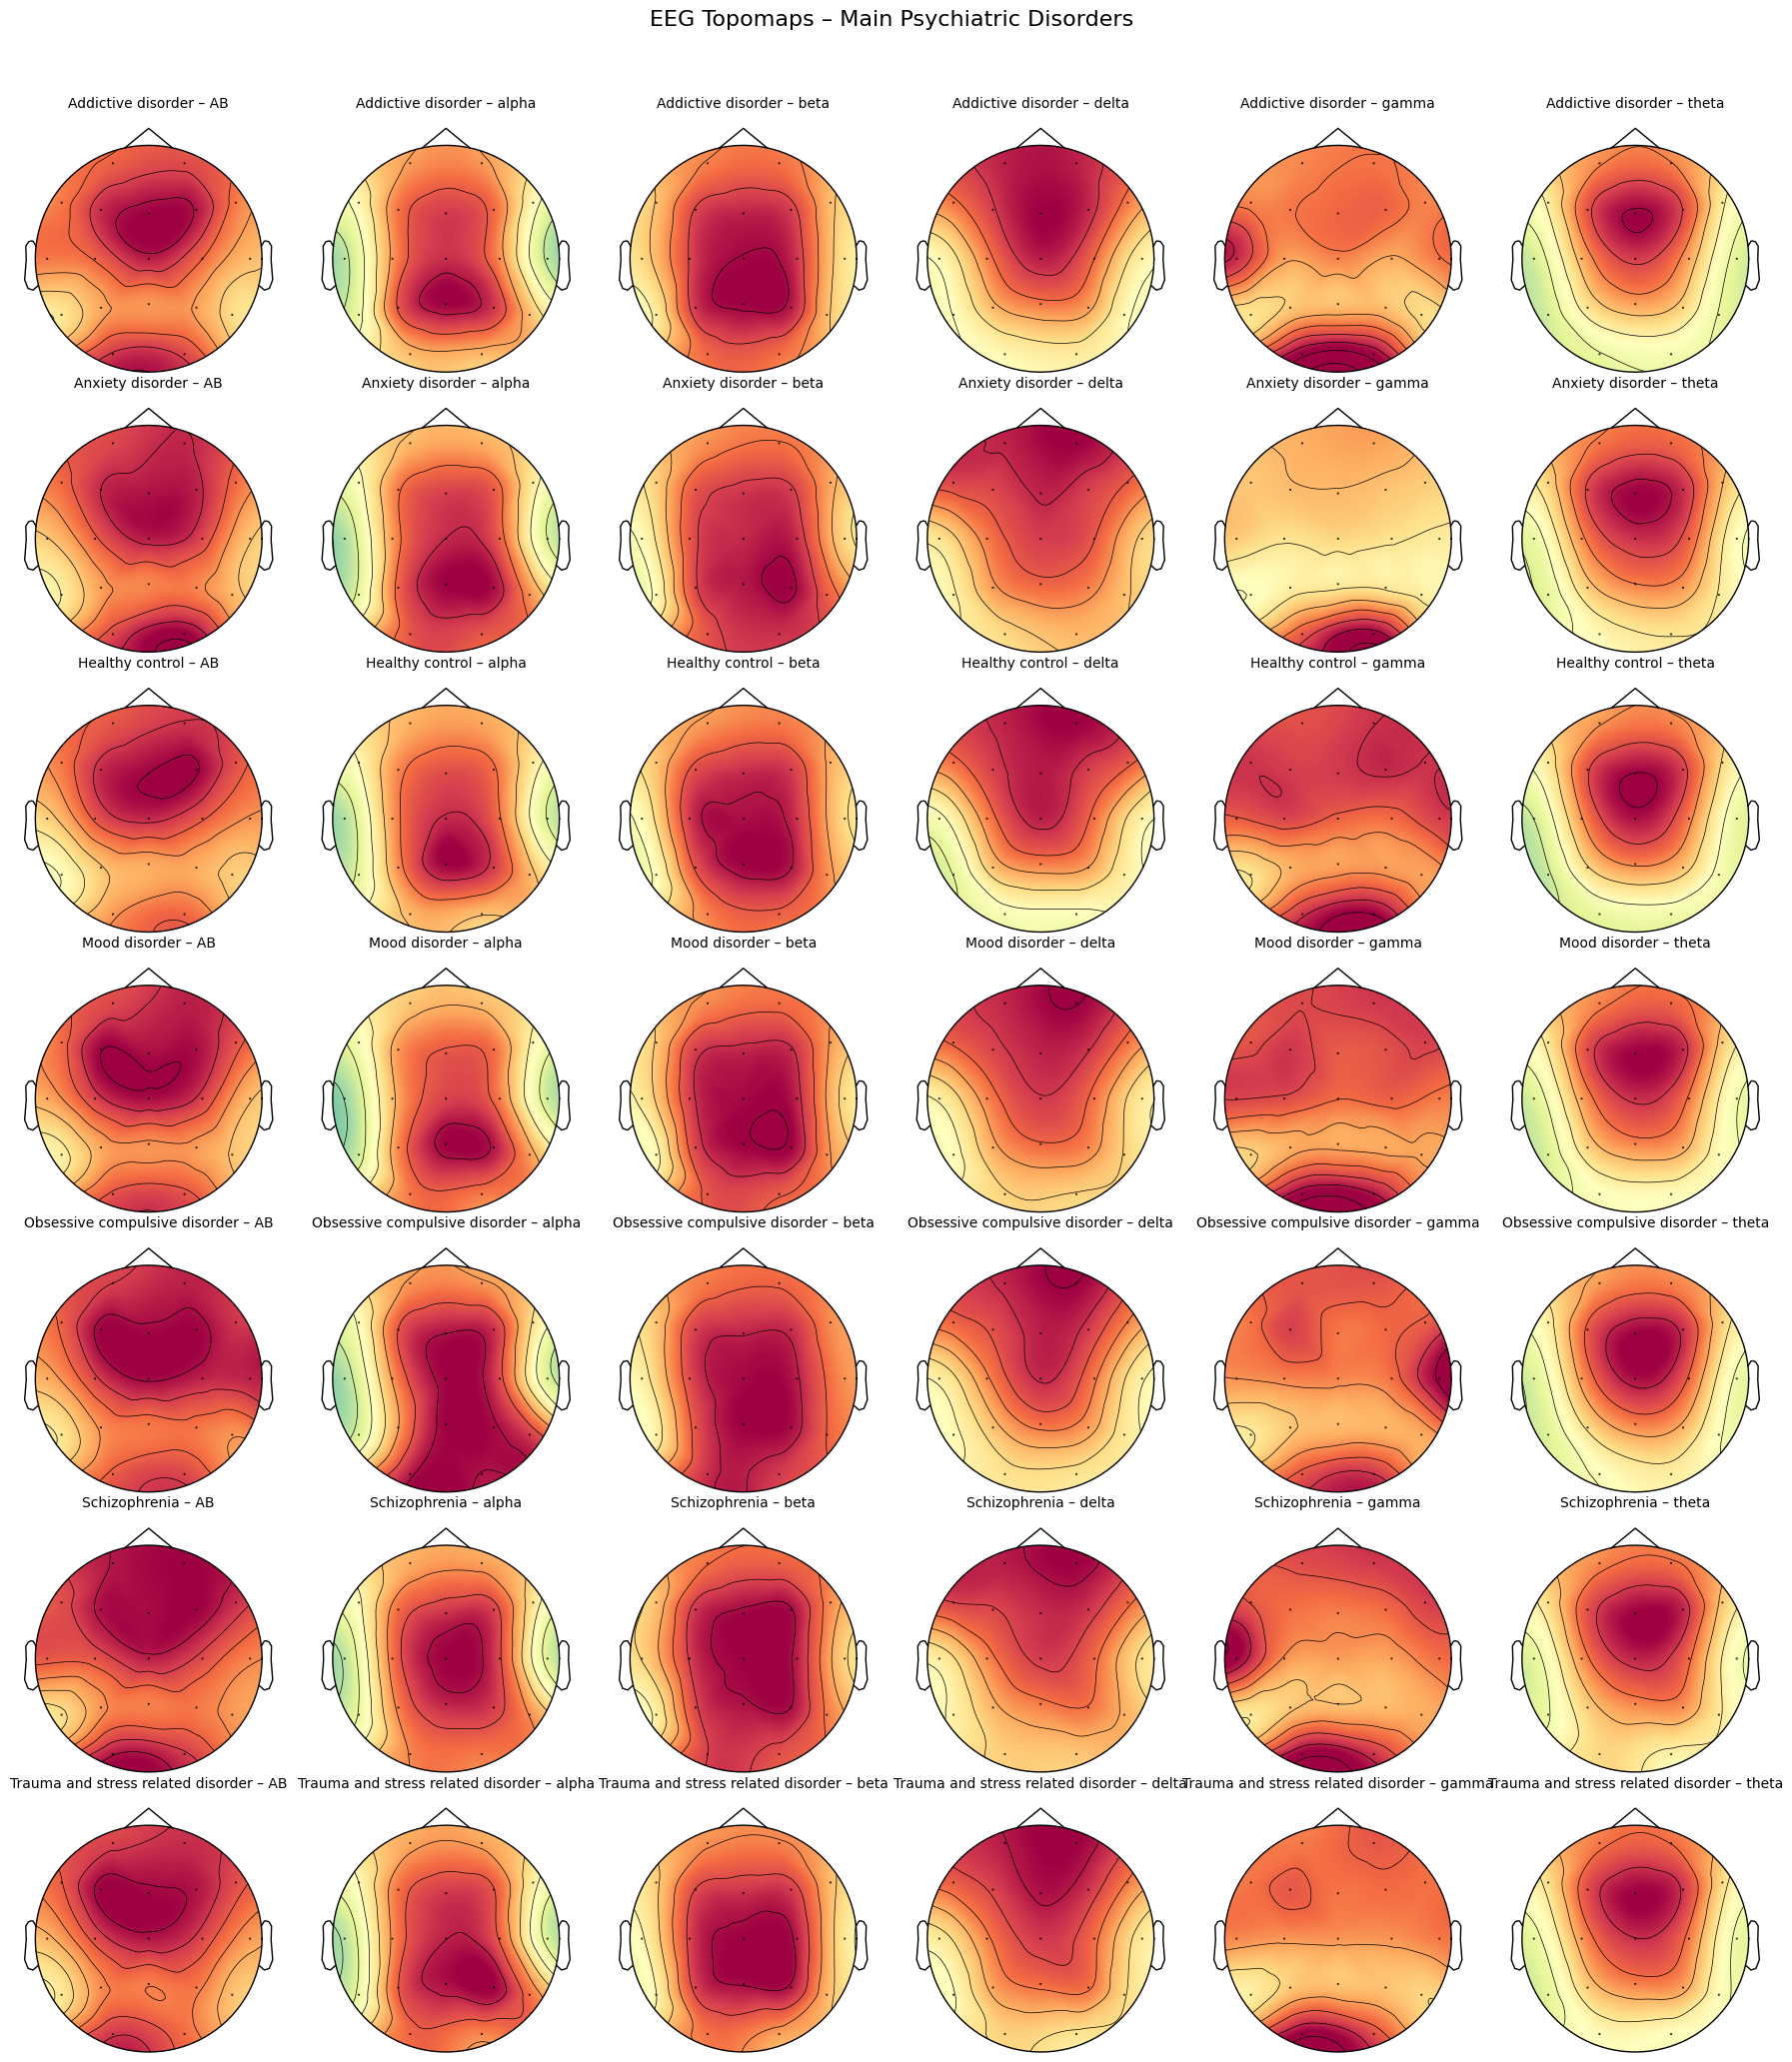

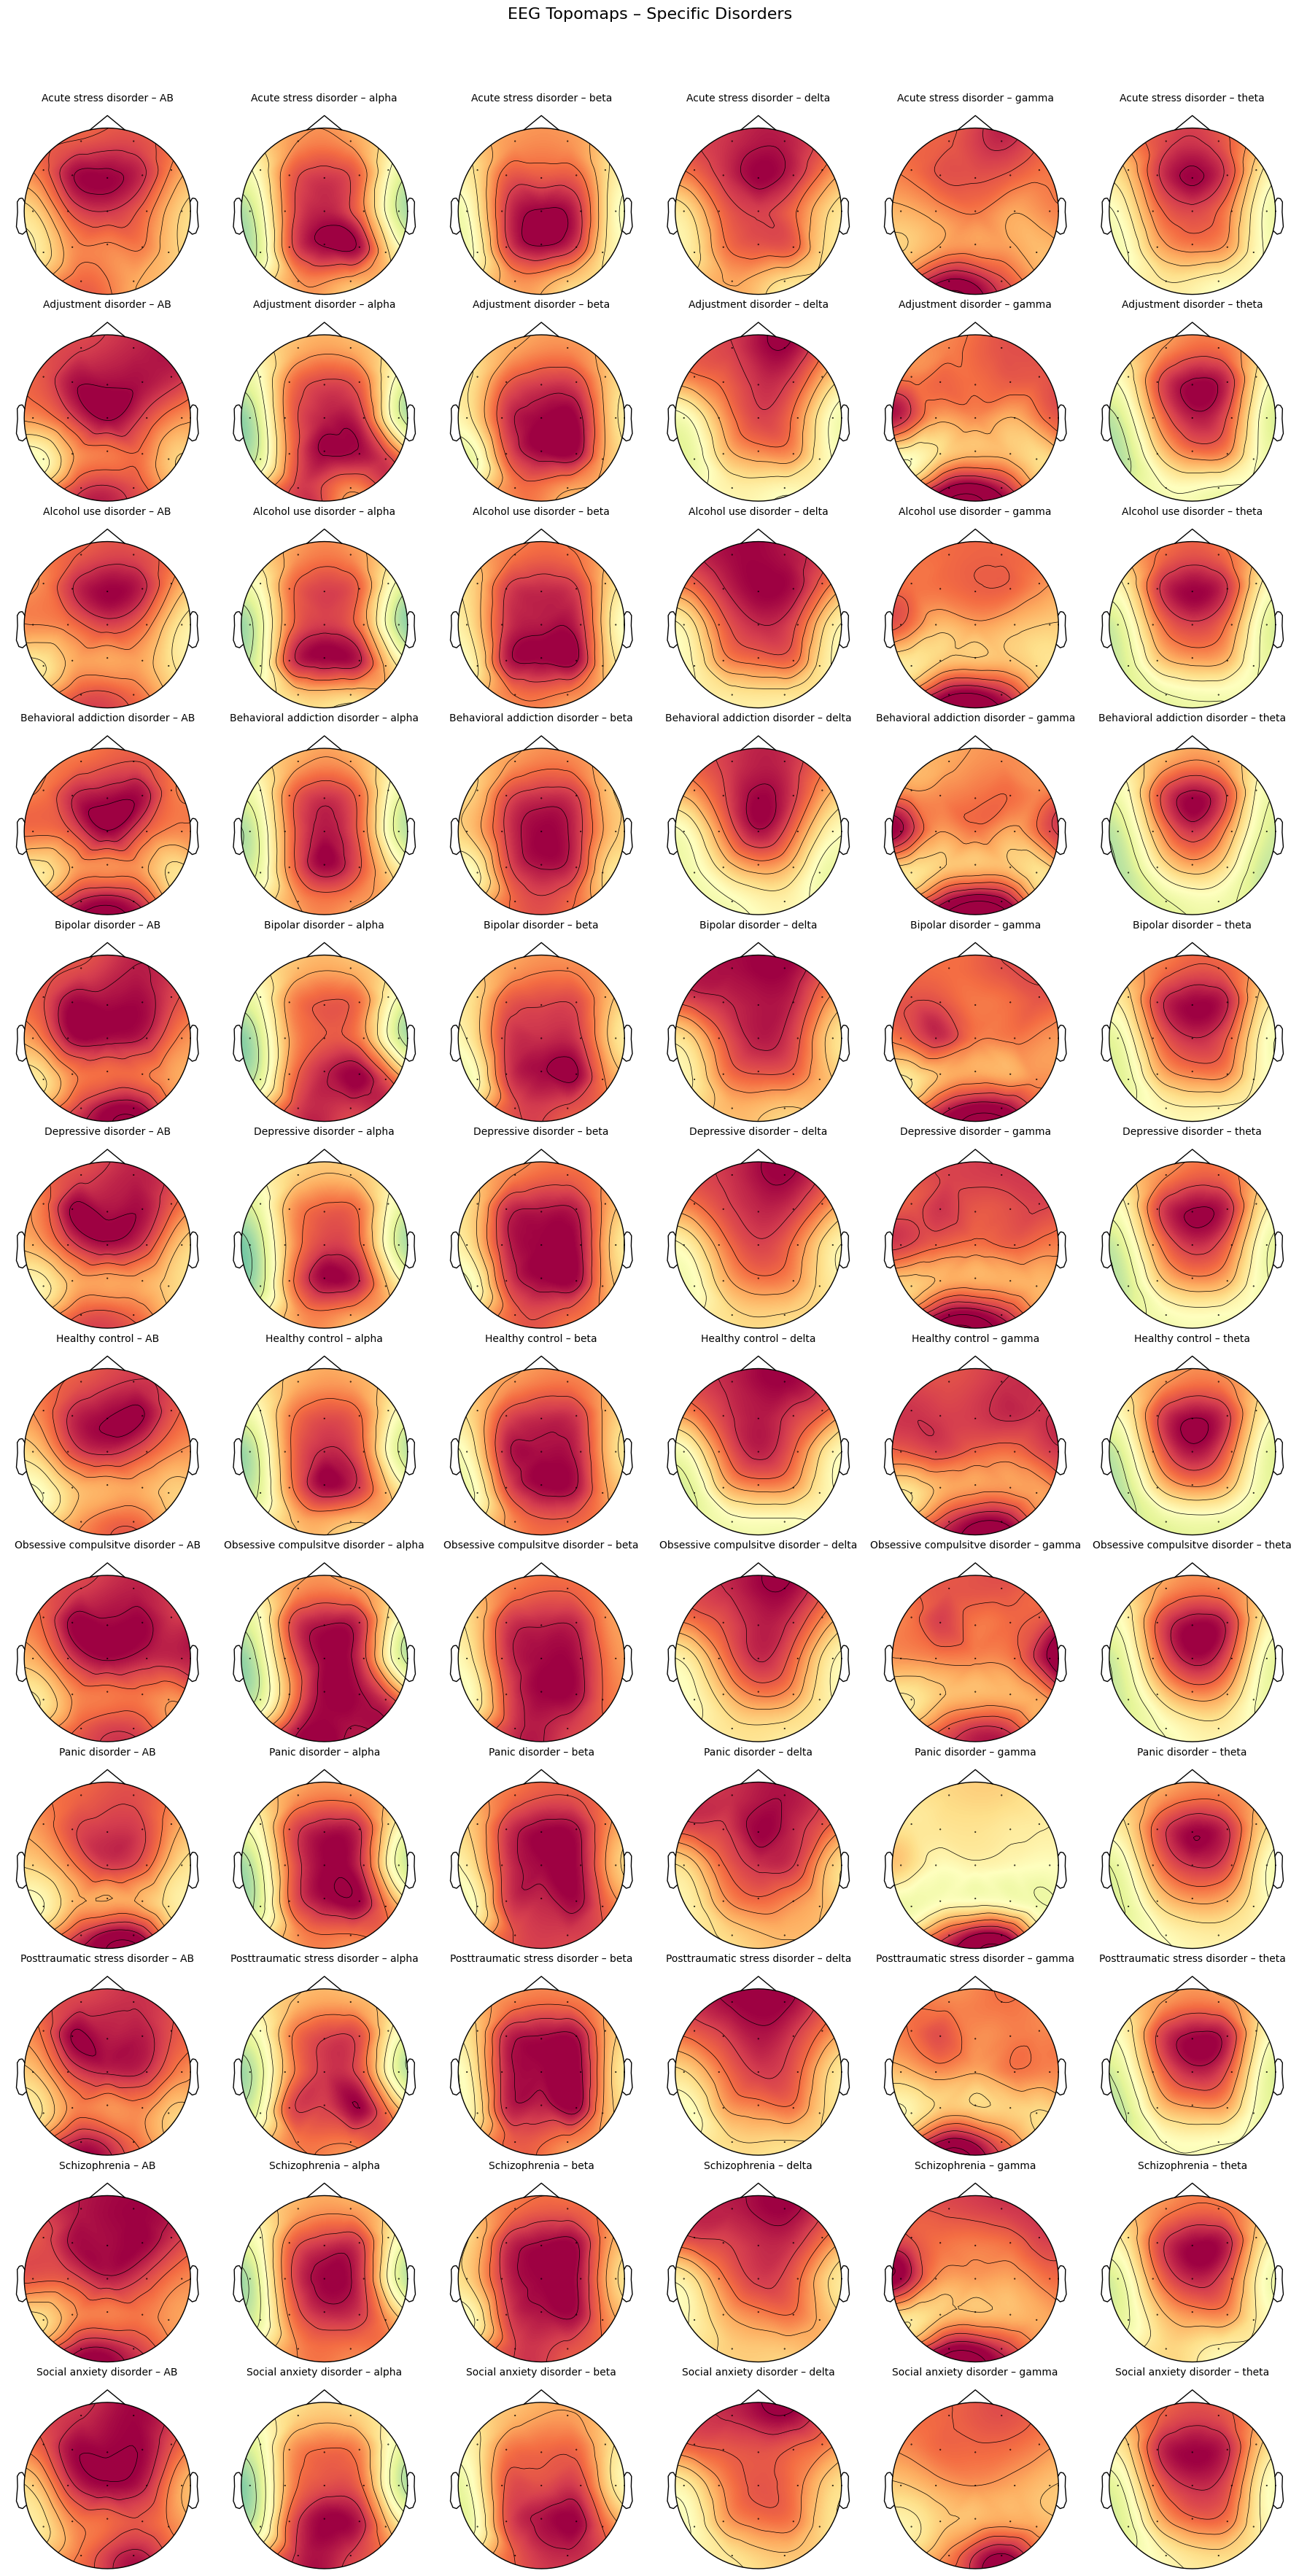

In [60]:
# --- Step G: Create Multi-Topomap EEG Visualizations ---

def plot_eeg_dataset(df_mean, title, bands, disorders, ch_positions, save_path=None):
    """
    Plots multiple EEG topomaps for each disorder × frequency band
    """
    n_rows, n_cols = len(disorders), len(bands)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    fig.suptitle(title, fontsize=16)

    for i, disorder in enumerate(disorders):
        for j, band in enumerate(bands):
            values = df_mean.loc[disorder, df_mean.columns.str.startswith(band)].to_numpy()
            ax = axes[i, j] if n_rows > 1 else axes[j]
            plot_eeg(values, ch_positions, ax, fig, ch_names=f"{disorder} – {band}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f" Figure saved to: {save_path}")
    plt.show()


# Select disorders and frequency bands
selected_disorders = list(main_mean.index)
selected_bands = sorted(set([col.split('.')[0] for col in main_mean.columns]))

# Plot for main disorders
plot_eeg_dataset(main_mean,
                 "EEG Topomaps – Main Psychiatric Disorders",
                 selected_bands,
                 selected_disorders,
                 chs,
)

# Plot for specific disorders (optional)
selected_specific = list(specific_mean.index)
plot_eeg_dataset(specific_mean,
                 "EEG Topomaps – Specific Disorders",
                 selected_bands,
                 selected_specific,
                 chs,)
